In [169]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

import rdkit
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit import DataStructs



#randomforestclassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


from mordred import Calculator, descriptors

#PCA
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

#compute accuracy
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef

In [63]:
df_tested_molecules1 = pd.read_csv('tested_molecules-1.csv')
df_tested_molecules2 = pd.read_csv('tested_molecules_v2.csv')

df = pd.concat([df_tested_molecules1, df_tested_molecules2], ignore_index=True)
df_molecules = df.copy(deep=True)
smiles_good_inhibitor = df[df['ALDH1_inhibition'] == 1].reset_index()
smiles_bad_inhibitor = df[df['ALDH1_inhibition'] == 0].reset_index()
PandasTools.AddMoleculeColumnToFrame(df_molecules, smilesCol='SMILES')
df_molecules.shape

(2000, 3)

In [64]:
def plot_mol (smiles_df, molecule_index):
    smiles = smiles_df['SMILES'][molecule_index]
    mol =Chem.MolFromSmiles(smiles)
    Draw.MolToMPL(mol, size=(200, 200))


In [65]:
def plot_list_mol(smiles_df):
    mol_list = []
    for smiles in smiles_df:
        for smiles in smiles_df['SMILES']:    # assuming your column is called Smiles
            mol = Chem.MolFromSmiles(smiles)
            Chem.SanitizeMol(mol,sanitizeOps=Chem.SANITIZE_SYMMRINGS|Chem.SANITIZE_SETCONJUGATION|Chem.SANITIZE_SETHYBRIDIZATION)
            mol.Compute2DCoords()
            mol_list.append(mol)
            Draw.MolToMPL(mol, size=(200, 200))

In [66]:
def rdkit_numpy_convert(fp):
    output = []
    for f in fp:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)

In [184]:
#split fingerprint data set in training and test set
seed = 42
X_train, X_test, y_train, y_test = train_test_split(df_molecules, df_molecules['ALDH1_inhibition'], stratify=df_molecules['ALDH1_inhibition'],test_size=0.25, random_state=seed)

,SMILES,ALDH1_inhibition,ROMol
1355,FC(F)(F)c1ccc(Oc2ccccc2Cl)nc1,0,<rdkit.Chem.rdchem.Mol object at 0x000002C1605...
647,N#Cc1ccccc1Sc1ccccc1C(=O)Nc1ccccc1,0,<rdkit.Chem.rdchem.Mol object at 0x000002C161B...
1648,c1ccc(Nc2nn[n-]n2)cc1,0,<rdkit.Chem.rdchem.Mol object at 0x000002C1655...
933,Cc1cc(C)c2oc(=O)cc(C[NH+]3CCN(Cc4ccc5c(c4)OCO5...,0,<rdkit.Chem.rdchem.Mol object at 0x000002C1654...
344,Cc1ccc(OCC(=O)Nc2ccc3c(c2)nc(CC[NH+]2CCN(C)CC2...,0,<rdkit.Chem.rdchem.Mol object at 0x000002C15F5...
...,...,...,...
1008,ClC(Cl)C(Cl)Cl,0,<rdkit.Chem.rdchem.Mol object at 0x000002C1654...
1233,N#Cc1c(F)cccc1NCc1cccs1,0,<rdkit.Chem.rdchem.Mol object at 0x000002C161B...
600,O=C(NCc1ccc(F)cc1)C(=O)NCC1OCCN1C(=O)c1ccc(Cl)cc1,0,<rdkit.Chem.rdchem.Mol object at 0x000002C15F5...
272,COc1ccc(OCc2nnc(SCC(=O)N(C)Cc3ccccc3)n2N)cc1,1,<rdkit.Chem.rdchem.Mol object at 0x000002C1654...


In [189]:
X_train_fp = rdkit_numpy_convert([AllChem.GetMorganFingerprintAsBitVect(x,3) for x in X_train['ROMol']])
X_test_fp = rdkit_numpy_convert([AllChem.GetMorganFingerprintAsBitVect(x,3) for x in X_test['ROMol']])
y_train_fp = y_train
y_test_fp = y_test 

In [69]:
#create 10 folds
cv = StratifiedKFold(n_splits=5)

In [70]:
# create grid search dictionary
param_grid = {"max_features": [X_train_fp.shape[1] // 10, X_train_fp.shape[1] // 7, X_train_fp.shape[1] // 5, X_train_fp.shape[1] // 3], 
              "n_estimators": [100, 250, 500]}

In [71]:
m = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=2, cv=cv, verbose=1)


In [72]:
m.fit(X_train_fp, y_train_fp)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'max_features': [204, 292, 409, 682],
                         'n_estimators': [100, 250, 500]},
             verbose=1)

In [73]:
m.cv_results_['mean_test_score']

array([0.79533333, 0.79066667, 0.794     , 0.78333333, 0.79133333,
       0.79266667, 0.79533333, 0.794     , 0.798     , 0.78866667,
       0.79066667, 0.79066667])

In [74]:

m.cv_results_['params']

[{'max_features': 204, 'n_estimators': 100},
 {'max_features': 204, 'n_estimators': 250},
 {'max_features': 204, 'n_estimators': 500},
 {'max_features': 292, 'n_estimators': 100},
 {'max_features': 292, 'n_estimators': 250},
 {'max_features': 292, 'n_estimators': 500},
 {'max_features': 409, 'n_estimators': 100},
 {'max_features': 409, 'n_estimators': 250},
 {'max_features': 409, 'n_estimators': 500},
 {'max_features': 682, 'n_estimators': 100},
 {'max_features': 682, 'n_estimators': 250},
 {'max_features': 682, 'n_estimators': 500}]

## Mordred descriptors model

In [196]:
#Split data into Test data set and training data set before doing anything.
mordred_calc = Calculator(descriptors, ignore_3D=True)

X_train_mor =  mordred_calc.pandas(mol for mol in X_train['ROMol'])
X_train_mor = X_train_mor.select_dtypes(include=['float64', 'int64', 'float'])

X_test_mor = mordred_calc.pandas(mol for mol in X_test['ROMol'])
X_test_mor = X_train_mor.select_dtypes(include=['float64', 'int64', 'float'])

y_train_mor = y_train
y_test_mor = y_test

1500it [01:30, 16.64it/s]
500it [00:36, 13.87it/s]


In [197]:
# Create correlation matrix
corr_matrix = X_train_mor.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
X_train_mor.drop(to_drop, axis=1, inplace=True)
X_test_mor.drop(to_drop, axis=1, inplace=True)
X_train_mor.shape

(1500, 606)

C:\Users\20213709\AppData\Local\miniconda3\envs\rdkitenv\lib\site-packages\matplotlib\transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


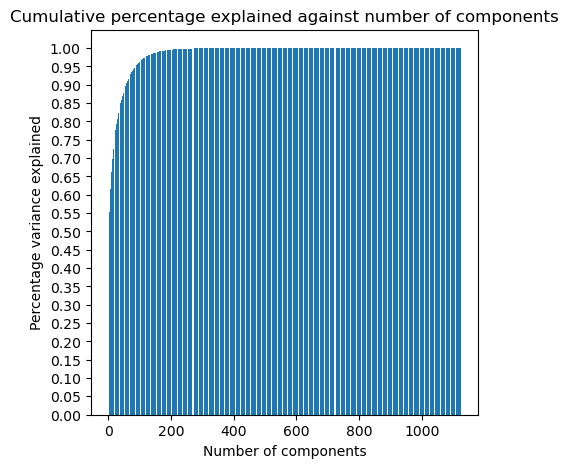

In [198]:
#perform PCA on training features as feature selection

scaler = StandardScaler()
matrix_mordred_scaled = scaler.fit_transform(X_train_mor)
df_train_mordred_pca = pd.DataFrame(matrix_mordred_scaled, columns=X_train_mor.columns)

covariance_matrix =X_train_mor_pca.cov().to_numpy()
w,v = LA.eig(covariance_matrix)
#print(w[0]/sum(w))
explained = np.cumsum(w/sum(w))
#print(explained)
amount_variables = [*range(len(explained))]

fig = plt.figure(figsize =(5, 5))
plt.bar(amount_variables, explained)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.ylabel('Percentage variance explained')
plt.xlabel('Number of components')
plt.title('Cumulative percentage explained against number of components')
plt.show()


In [199]:
#PCA on mordred
pca = decomposition.PCA(n_components=100)
PCA_mordred_features = pca.fit_transform(df_train_mordred_pca)
pca_mordred_df = pd.DataFrame(data=PCA_mordred_features, columns=[ 'PC'+str(x) for x in range(100)])
pca_mordred_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99
0,0.633542,17.919920,1.347384,-3.386596,-2.775244,7.715497,0.464557,-0.276342,-1.938722,-0.500770,...,0.568193,-1.026530,0.437672,0.442831,-0.044769,-0.979884,0.158881,0.145559,0.779471,0.364755
1,-4.461686,-4.100818,-4.150625,1.478995,-5.477337,5.612817,-2.860199,3.041699,3.152401,-3.063170,...,-0.400234,1.206310,0.716470,-0.351073,0.233664,0.272419,-0.094454,-0.209857,-0.984781,-0.109777
2,-13.684132,3.693289,-1.101350,-5.738936,3.371777,0.038671,-4.537657,-5.766435,-2.037708,-2.226828,...,-2.007739,-1.117701,-0.916927,0.235034,0.557998,2.370806,-0.905104,-1.303237,-0.574234,0.092136
3,9.358450,-7.540071,-3.548709,-1.507020,4.981960,0.576375,6.205876,3.039908,1.518364,0.954327,...,-0.472929,-0.099429,-0.477996,-1.648166,-0.333231,-0.729639,0.113088,0.061759,0.102763,-0.106167
4,7.742822,-8.345265,-1.074737,-4.414908,0.708140,-2.688583,5.821586,0.555515,0.093836,1.511344,...,0.455172,-0.088171,-0.837617,0.236788,-0.191118,-0.018801,-0.008625,0.102659,0.132958,-0.606686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-21.145967,5.786537,26.609680,6.312787,-13.748300,1.832678,14.911124,3.945801,-5.706120,5.310161,...,0.678466,-1.811301,-4.504644,1.541078,-0.406181,1.505393,0.903195,-1.819584,1.222198,-0.298057
1496,-9.031807,2.678430,-0.624763,1.428246,-2.551770,1.192310,-5.519886,-0.975159,-1.342875,-0.125172,...,-0.919168,-1.161423,0.585663,-0.433348,-0.147463,-0.318339,0.518448,0.074056,0.242042,-0.077666
1497,8.362447,2.638183,-1.769212,-3.398216,-5.442211,-2.252619,-1.331655,1.133638,1.245730,6.054873,...,-0.333038,0.177857,1.198706,0.272373,0.472358,0.233433,-0.962680,-0.080689,-0.714259,0.280627
1498,4.396619,-3.218267,-3.090548,-2.403945,-5.713228,-5.329692,0.761252,0.924500,-0.590194,0.954617,...,0.378479,-0.576127,-0.899795,2.198004,-0.305925,-1.534556,-1.010868,0.007519,-0.150536,0.161630


Text(0.5, 1.0, 'Scoreplot of PC1 and PC2 grouped by Activity')

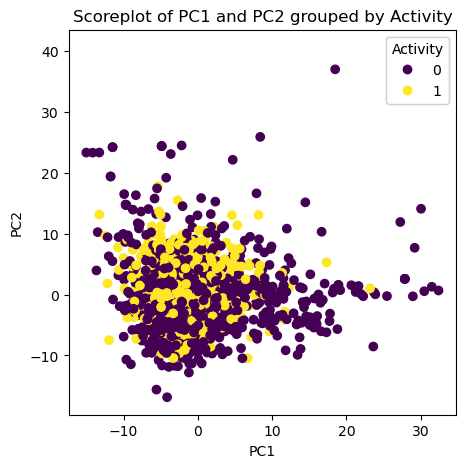

In [156]:
fig, ax1 = plt.subplots(figsize=(5,5))

#plot PC1 against PC2 in a scatter matrix and group colours by activity.
scatter = ax1.scatter(pca_mordred_df['PC1'], pca_mordred_df['PC2'], c= y_train_mor, cmap='viridis')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

legend1 = ax1.legend(*scatter.legend_elements(),
                    loc="upper right", title="Activity")
ax1.add_artist(legend1)
ax1.set_title('Scoreplot of PC1 and PC2 grouped by Activity')

In [157]:
#create 10 folds
cv = StratifiedKFold(n_splits=5)

In [158]:
# create grid search dictionary
param_grid = {"max_features": [pca_mordred_df.shape[1] // 10, pca_mordred_df.shape[1] // 7, pca_mordred_df.shape[1] // 5, pca_mordred_df.shape[1] // 3], 
              "n_estimators": [100, 250, 500]}

In [159]:
m_mordred = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=2, cv=cv, verbose=1)

In [160]:
# run model building
m_mordred.fit(pca_mordred_df, y_train_mor)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'max_features': [10, 14, 20, 33],
                         'n_estimators': [100, 250, 500]},
             verbose=1)

In [161]:
m_mordred.cv_results_['mean_test_score']

array([0.768     , 0.75533333, 0.76466667, 0.75133333, 0.762     ,
       0.76466667, 0.76      , 0.774     , 0.762     , 0.77333333,
       0.75733333, 0.768     ])

In [162]:
m_mordred.cv_results_['params']

[{'max_features': 10, 'n_estimators': 100},
 {'max_features': 10, 'n_estimators': 250},
 {'max_features': 10, 'n_estimators': 500},
 {'max_features': 14, 'n_estimators': 100},
 {'max_features': 14, 'n_estimators': 250},
 {'max_features': 14, 'n_estimators': 500},
 {'max_features': 20, 'n_estimators': 100},
 {'max_features': 20, 'n_estimators': 250},
 {'max_features': 20, 'n_estimators': 500},
 {'max_features': 33, 'n_estimators': 100},
 {'max_features': 33, 'n_estimators': 250},
 {'max_features': 33, 'n_estimators': 500}]

In [166]:
#scale test data
X_test_mor_scaled = scaler.transform(X_test_mor)
X_test_PCA = pca.transform(X_test_mor_scaled)
df_X_test_PCA = pd.DataFrame(data=X_test_PCA, columns=[ 'PC'+str(x) for x in range(100)])

C:\Users\20213709\AppData\Local\miniconda3\envs\rdkitenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [180]:
#let model predict
pred_mordred = m_mordred.predict(X_test_PCA)

C:\Users\20213709\AppData\Local\miniconda3\envs\rdkitenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\20213709\AppData\Local\miniconda3\envs\rdkitenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,not inhibitor,inhibitor
7,0.176,0.824
382,0.248,0.752
38,0.284,0.716
10,0.284,0.716
151,0.284,0.716
...,...,...
226,0.992,0.008
70,0.996,0.004
422,0.996,0.004
222,0.996,0.004


In [170]:
accuracy_score(y_test_mor, pred_mordred)

0.798

In [171]:
matthews_corrcoef(y_test_mor, pred_mordred)

0.487538090401277

In [172]:
cohen_kappa_score(y_test_mor, pred_mordred)

0.47395833333333337

In [183]:
pred_prob_mordred = m_mordred.predict_proba(X_test_PCA)

df_pred_prob_mordred = pd.DataFrame(data=pred_prob_mordred, columns=['not inhibitor', 'inhibitor'])
df_pred_prob_mordred.sort_values(by='inhibitor', ascending=False)
X_test_mor

C:\Users\20213709\AppData\Local\miniconda3\envs\rdkitenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpMAD_A,VE1_A,VR1_A,nAromAtom,nAtom,...,JGI6,JGI7,JGI8,JGI9,JGI10,JGT10,TopoShapeIndex,SRW05,TSRW10,mZagreb1
334,0,0,38.848165,2.462647,4.925293,1.387434,4.668595,246.832390,12,54,...,0.012680,0.005324,0.003773,0.003798,0.002968,0.271124,0.833333,0.000000,63.637675,5.888889
1235,0,1,23.878321,2.384390,4.603150,1.326573,3.531252,173.924144,15,30,...,0.014762,0.014625,0.003948,0.010666,0.009437,0.379657,0.833333,2.397895,64.824124,4.555556
398,0,0,25.436017,2.261523,4.494136,1.271801,3.808341,139.799520,11,33,...,0.018561,0.010589,0.008568,0.009176,0.004362,0.416512,0.857143,2.397895,66.132838,6.555556
98,0,0,30.997613,2.457515,4.747138,1.347722,3.942599,223.085314,15,40,...,0.015802,0.010180,0.007307,0.007865,0.005332,0.348159,0.833333,3.044522,73.487639,5.527778
541,0,0,18.475475,2.249391,4.498782,1.231698,3.412412,84.698255,6,31,...,0.024671,0.015129,0.013958,0.005000,0.008264,0.423655,0.833333,0.000000,45.652835,5.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,0,0,18.626607,2.690274,5.128557,1.095683,3.456393,135.511655,0,46,...,0.021882,0.000000,0.000000,0.000000,0.000000,0.818964,0.750000,2.397895,66.790072,10.111111
1579,0,0,20.666207,2.269917,4.539834,1.291638,3.812985,72.218215,12,27,...,0.009419,0.011521,0.018105,0.007500,0.012346,0.416600,1.000000,0.000000,47.815263,4.944444
1870,0,0,32.128166,2.386712,4.773423,1.285127,4.294911,247.807255,12,47,...,0.019410,0.016493,0.010821,0.009805,0.004129,0.431219,1.000000,0.000000,59.568973,8.138889
497,0,1,35.646291,2.372061,4.744123,1.273082,4.403265,453.936828,12,50,...,0.015090,0.013123,0.007818,0.006900,0.005974,0.400478,1.000000,0.000000,62.903780,8.888889
